In [1]:
import altair as alt
import pandas as pd
import numpy as np

import utils

In [2]:
# Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv
df = utils.read_movie_data()
df.head()

budget   genre original_language                               title  \
2  245000000  Action                en                             Spectre   
3  250000000  Action                en               The Dark Knight Rises   
4  260000000  Action                en                         John Carter   
7  280000000  Action                en             Avengers: Age of Ultron   
9  250000000  Action                en  Batman v Superman: Dawn of Justice   

         production_country release_date     revenue  runtime  vote_average  \
2            United Kingdom   2015-10-26   880674609    148.0           6.3   
3  United States of America   2012-07-16  1084939099    165.0           7.6   
4  United States of America   2012-03-07   284139100    132.0           6.1   
7  United States of America   2015-04-22  1405403694    141.0           7.3   
9  United States of America   2016-03-23   873260194    151.0           5.7   

   vote_count  release_year  
2        4466          2015  
3        9106          2012  
4        2124          2012  
7        6767          2015  
9        7004          2016

# Setting the data in altair

In [3]:
# Data
data = alt.Chart(df)

# What's the relationship between vote_count and vote_average?

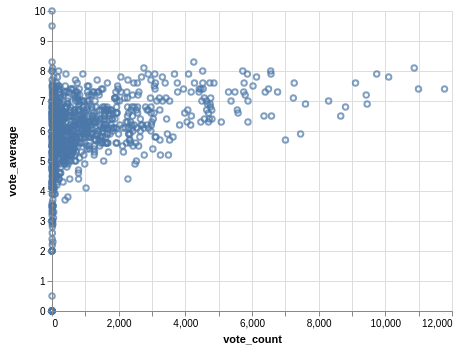

In [13]:
relationship = data.mark_point().encode(
    x='vote_count',
    y='vote_average'
)
# interactive
relationship

# How many movies were made per genre?

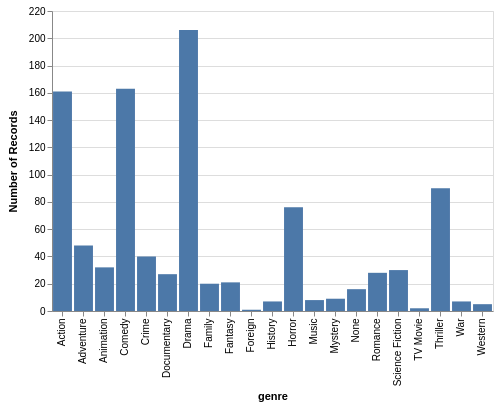

In [6]:
genre = data.mark_bar().encode(
    x='genre',
    y='count()'
)
genre

# What kind of budget do different genres have?

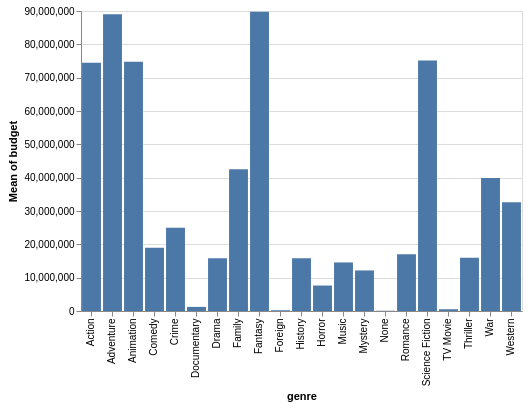

In [5]:
genre_budget = data.mark_bar().encode(
    x='genre',
    y='mean(budget)'
)
genre_budget

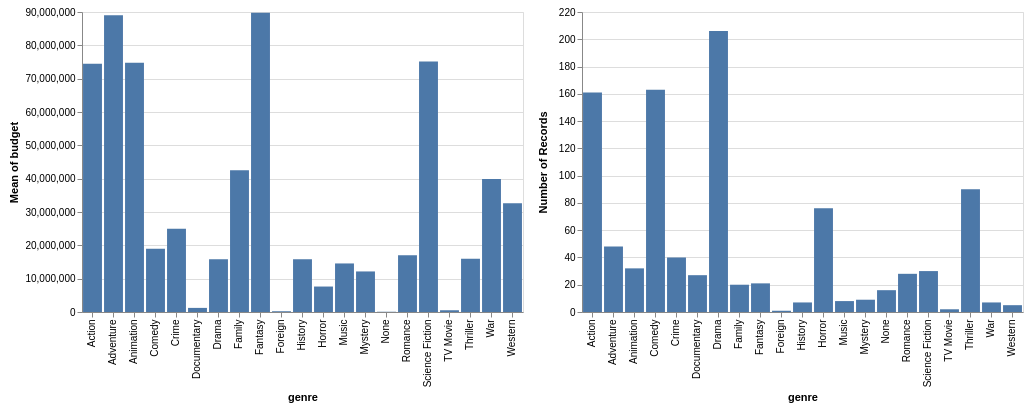

In [6]:
genre_budget | genre

# How are people voting?

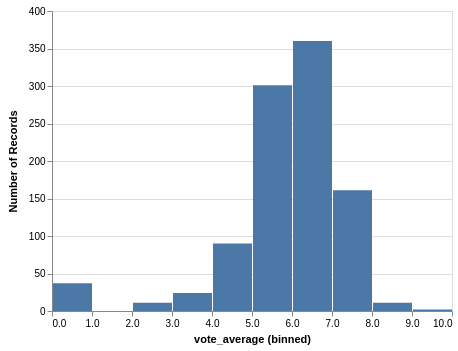

In [11]:
votes = data.mark_bar().encode(
    x=alt.X('vote_average', bin=True),
    y='count()'
)
votes

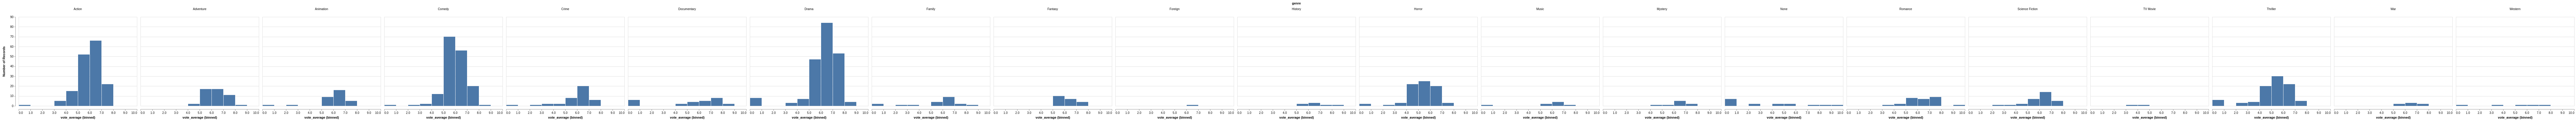

In [12]:
votes.encode(column='genre')

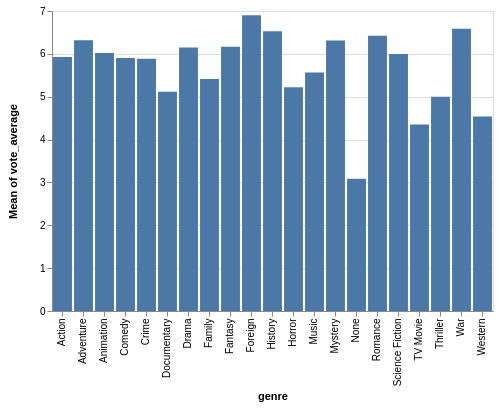

In [8]:
data.mark_bar().encode(
    y='mean(vote_average)',
    x='genre'
)

# Let's compare Action vs Drama specifically

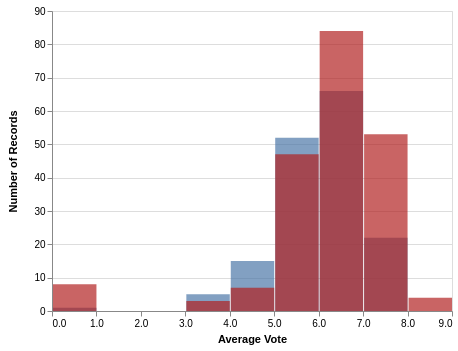

In [9]:
genre_hist = data.mark_bar().encode(
    x=alt.X('vote_average', bin=True, title='Average Vote'),
    y='count()',
    opacity=alt.value(0.7))

action_genre = genre_hist.transform_filter('datum.genre == "Action"')
drama_genre = genre_hist.encode(color=alt.value('firebrick')).transform_filter('datum.genre == "Drama"')
action_genre + drama_genre

# Popularity vs Budget

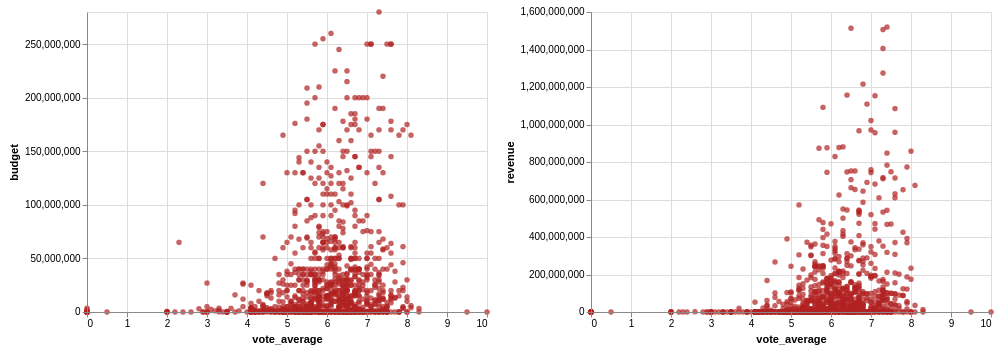

In [12]:
selection = alt.selection_interval(empty='all')

base = data.mark_circle().encode(
    x='vote_average',
    tooltip='title',
    color=alt.condition(selection, alt.value('firebrick'), alt.value('lightgray'))
).properties(
    selection=selection
)

base.encode(y='budget') | base.encode(y='revenue')

# Budget vs Revenue - Does a large budget equal large revenue?

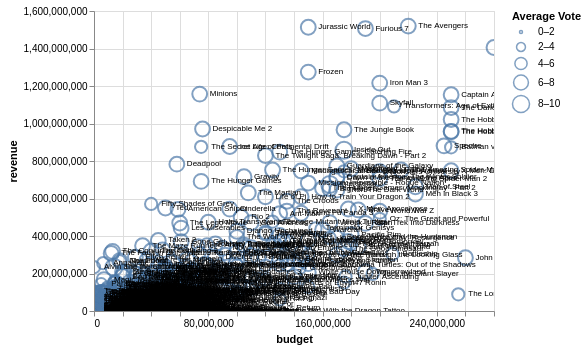

In [26]:
budget_revenue_base = data.mark_point().encode(
    x='budget',
    y='revenue',
)

vote_average = budget_revenue_base.encode(
    size=alt.Size('vote_average', bin=True, title='Average Vote'),
)

title_text = budget_revenue_base.mark_text(fontSize=8, dx=10, align='left', baseline='middle').encode(
    text='title',
    color=alt.value('black'),
)

(vote_average + title_text).interactive()

# Let's build a report!

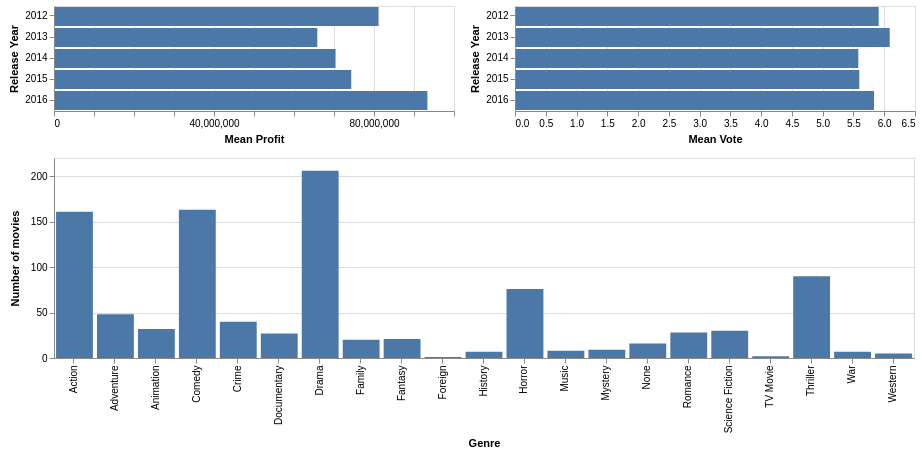

In [40]:
selection = alt.selection_single(fields=['genre'])


budget = data.mark_bar().encode(
    y=alt.Y('release_year:O', title='Release Year'),
    x=alt.X('mean(vote_average)', title='Mean Vote')
).transform_filter(
    selection
)

profit = data.mark_bar().encode(
    y=alt.Y('release_year:O', title='Release Year'),
    x=alt.X('mean(profits):Q', title='Mean Profit')
).transform_calculate(
    profits='datum.revenue - datum.budget'
).transform_filter(
    selection
)

releases = data.mark_bar().encode(
    x=alt.X('genre', title='Genre'),
    y=alt.Y('count()', title='Number of movies'),
    opacity=alt.condition(selection, alt.value(1.0), alt.value(0.1))
).properties(
    height=200,
    width=860,
    selection=selection
)

our_report = alt.vconcat(alt.hconcat(profit, budget), releases)
our_report

In [33]:
from jinja2 import FileSystemLoader, Environment

In [46]:
fs = FileSystemLoader('./templates/')
env = Environment(loader=fs)

In [57]:
comments = """
Drama is the most populous, but profits have been swingy. Critical acclaim does not seem to correspond to the profits made.<br>
Comedies have seen a steady increase in profits over the years - it is also the third most populous genre among the movies analysed.<br>
Action movies have generated large profits and seem to consistently be crowd pleasers
"""

In [59]:
chart_title = "Comparing Profits and Votes per Genre"

In [60]:
template = env.get_template('template.html')

with open('output.html', 'w') as f:
    chart_data = our_report.to_json()
    f.write(template.render(chart=chart_data, comments=comments, chart_title=chart_title))